In [4]:
import matplotlib.pyplot as plt
from retinaface import RetinaFace as RF
from facenet_pytorch import InceptionResnetV1, MTCNN
from deepface import DeepFace
from PIL import Image
import torchvision.transforms as transforms
from torchvision.transforms import functional as _F
import torch.nn.functional as F
import numpy as np
import cv2
import torch

In [8]:
transform = transforms.Compose([transforms.PILToTensor()])

In [5]:
def fixed_image_standardization(image_tensor):
    processed_tensor = (image_tensor - 127.5) / 128.0
    return processed_tensor

In [6]:
def imresample(img, sz):
    im_data = F.interpolate(img, size=sz, mode="area")
    return im_data

In [7]:
def crop_resize(img, box, image_size):
    x = box[0]
    y = box[1]
    w = box[2] - x
    h = box[3] - y

    out = img.crop(box).copy().resize((image_size, image_size), Image.BILINEAR)
    return out

In [8]:
def get_size(img):
    if isinstance(img, (np.ndarray, torch.Tensor)):
        return img.shape[1::-1]
    else:
        return img.size


def extract_face(img, box, image_size=160, margin=0):
    margin = [
        margin * (box[2] - box[0]) / (image_size - margin),
        margin * (box[3] - box[1]) / (image_size - margin),
    ]
    raw_image_size = get_size(img)
    box = [
        int(max(box[0] - margin[0] / 2, 0)),
        int(max(box[1] - margin[1] / 2, 0)),
        int(min(box[2] + margin[0] / 2, raw_image_size[0])),
        int(min(box[3] + margin[1] / 2, raw_image_size[1])),
    ]

    face = crop_resize(img, box, image_size)

    face = np.array(face, dtype=np.float32)

    return face

In [163]:
img1 = Image.open("./datasets/people/CFAF0686-D96D-434B-B3E2-8A5274D6EBBD_1_105_c.jpeg")
img2 = Image.open("./datasets/people/028C2197-6F21-4DBB-A868-AC93EE45A1F9_4_5005_c.jpeg")

## Face Detection Using RetinaFace

In [171]:
faces1 = RF.detect_faces(
    np.array(img1),
    threshold=0.999
)
faces2 = RF.detect_faces(
    np.array(img2),
)

In [172]:
# facial_area = faces1['face_1']["facial_area"]

# x = facial_area[0]
# y = facial_area[1]
# w = facial_area[2] - x
# h = facial_area[3] - y

# facial_img = img1[y : y + h, x : x + w]

In [173]:
faces1

{'face_1': {'score': 0.9995081424713135,
  'facial_area': [243, 215, 278, 256],
  'landmarks': {'right_eye': [257.3954, 231.30626],
   'left_eye': [272.53067, 233.42894],
   'nose': [265.75168, 240.37901],
   'mouth_right': [256.58914, 245.9115],
   'mouth_left': [269.15405, 247.66414]}},
 'face_2': {'score': 0.9992730021476746,
  'facial_area': [942, 186, 987, 234],
  'landmarks': {'right_eye': [949.0661, 203.09398],
   'left_eye': [968.908, 202.32014],
   'nose': [956.5544, 212.60606],
   'mouth_right': [951.9282, 221.8982],
   'mouth_left': [967.45734, 221.30684]}},
 'face_3': {'score': 0.9992691874504089,
  'facial_area': [658, 353, 691, 392],
  'landmarks': {'right_eye': [665.7216, 368.51956],
   'left_eye': [681.43835, 366.0988],
   'nose': [674.2156, 375.92014],
   'mouth_right': [668.9248, 383.11172],
   'mouth_left': [682.5485, 381.16043]}},
 'face_4': {'score': 0.9991152882575989,
  'facial_area': [677, 212, 703, 242],
  'landmarks': {'right_eye': [681.6033, 225.94353],
   'l

In [47]:
faces2

{'face_1': {'score': 0.9995688796043396,
  'facial_area': [138, 106, 216, 202],
  'landmarks': {'right_eye': [164.38675, 141.45244],
   'left_eye': [200.0001, 145.10207],
   'nose': [183.19397, 160.37762],
   'mouth_right': [165.2528, 177.83974],
   'mouth_left': [192.29953, 181.0441]}}}

In [40]:
for key, value in faces1.items():
    print(key, value['facial_area'])

face_1 [757, 318, 866, 444]
face_2 [595, 280, 727, 452]
face_3 [317, 234, 578, 563]


In [184]:
face1 = extract_face(img1, faces1['face_2']['facial_area'], 160)
face2 = extract_face(img2, faces2['face_1']['facial_area'], 160)

In [185]:
threshold = 0.998

faces1_below_threshold = []
faces1_above_threshold = []

for key, value in faces1.items():
    if value['score'] <= threshold:
        faces1_below_threshold.append(faces1[key])
    else:
        faces1_above_threshold.append(faces1[key])
        
imgs_below_threshold = []
for face in faces1_below_threshold:
    imgs_below_threshold.append(Image.fromarray(extract_face(img1, face['facial_area'], 160).astype(np.uint8)))
    
imgs_above_threshold = []
for face in faces1_above_threshold:
    imgs_above_threshold.append(Image.fromarray(extract_face(img1, face['facial_area'], 160).astype(np.uint8)))

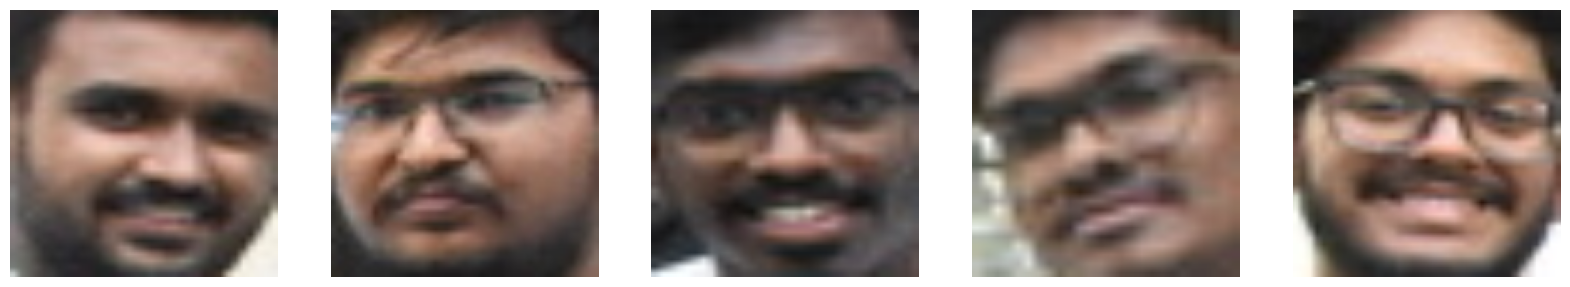

In [186]:
# display all images in imgs
fig, axes = plt.subplots(1, len(imgs_above_threshold), figsize=(20, 20))

for i, img in enumerate(imgs_above_threshold):
    axes[i].imshow(img)
    axes[i].axis("off")
    
plt.show()

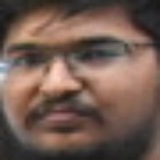

In [187]:
Image.fromarray(face1.astype(np.uint8))

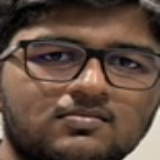

In [188]:
Image.fromarray(face2.astype(np.uint8))

In [189]:
# face1 = crop_resize(img1, faces1['face_1']['facial_area'], 256)
# face2 = crop_resize(img2, faces2['face_1']['facial_area'], 256)

In [190]:
# f1 = _F.to_tensor(np.float32(face1))
# f2 = _F.to_tensor(np.float32(face2))

In [191]:
# # display face1 using f1 tensor
# plt.imshow(f2.int().permute(1, 2, 0))

In [192]:
def get_embedding(img):
    model = InceptionResnetV1(pretrained="vggface2").eval()
    embedding = model(img.unsqueeze(0))
    return embedding

In [193]:
face1 = fixed_image_standardization(face1)
face2 = fixed_image_standardization(face2)
face1_embedding = get_embedding(_F.to_tensor(face1.astype(np.float32)))
face2_embedding = get_embedding(_F.to_tensor(face2.astype(np.float32)))

In [194]:
# cosine similarity
cosine_similarity = F.cosine_similarity(face1_embedding, face2_embedding).item()
cosine_similarity

0.6108813881874084

## Face Detection Using MTCNN

In [63]:
mtcnn = MTCNN(keep_all=True, thresholds=[0.75, 0.8, 0.8], post_process=True)

face1, prob1 = mtcnn(img1, return_prob=True)
face2, prob2 = mtcnn(img2, return_prob=True)

In [64]:
len(face1), len(face2)

(3, 1)

In [65]:
face1 = face1[0]
face2 = face2[0]

In [66]:
face1_embedding = get_embedding(face1)
face2_embedding = get_embedding(face2)

cosine_similarity = F.cosine_similarity(face1_embedding, face2_embedding).item()
cosine_similarity

0.6611345410346985

## DeepFace (RetinaFace + FaceNet)

In [67]:
from deepface import DeepFace

In [68]:
model = DeepFace.build_model("Facenet512")

In [69]:
img_embedding1 = DeepFace.represent(
    img_path=np.array(img1),
    model_name="Facenet512",
    detector_backend="retinaface",
    normalization="base",
)
img_embedding2 = DeepFace.represent(
    img_path=np.array(img2),
    model_name="Facenet512",
    detector_backend="retinaface",
    normalization="base",
)

In [70]:
def to_box(area):
    x = area['x']
    y = area['y']
    w = area['w']
    h = area['h']
    
    return [x, y, x + w, y + h]

In [80]:
face1 = crop_resize(img1, to_box(img_embedding1[1]['facial_area']), 160)
face2 = crop_resize(img2, to_box(img_embedding2[0]['facial_area']), 160)

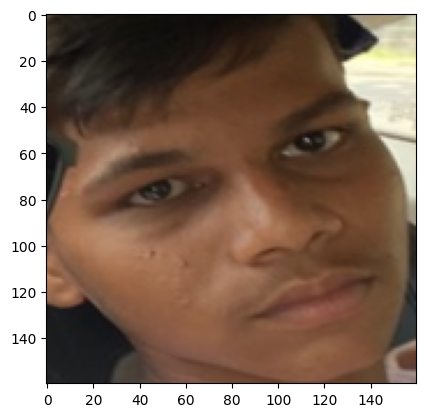

In [81]:
plt.imshow(face1)

In [82]:
embedding_1 = torch.tensor(img_embedding1[0]['embedding']).unsqueeze(0)
embedding_2 = torch.tensor(img_embedding2[0]['embedding']).unsqueeze(0)

In [83]:
cosine_similarity = F.cosine_similarity(fixed_image_standardization(embedding_1), fixed_image_standardization(embedding_2)).item()
cosine_similarity

0.9999507069587708

## DeepFace Manual (RetinaFace + FaceNet)

In [84]:
from deepface.modules.modeling import build_model
from deepface.modules.preprocessing import resize_image, normalize_input

In [85]:
from deepface import DeepFace

In [86]:
FaceNet = build_model(task="facial_recognition", model_name="Facenet512")
target_size = FaceNet.input_shape

In [87]:
FaceNet.input_shape

(160, 160)

In [88]:
import torchvision.transforms as transforms

In [89]:

transform = transforms.Compose([
    transforms.Resize(512),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])

In [90]:
def embedding_deepface(img):
    img = np.array(img)
    img = img[:, :, ::-1]
    img = resize_image(img, target_size=(target_size[1], target_size[0]))
    img = normalize_input(img=img, normalization="Facenet2018")
    embedding = FaceNet.forward(img)

    return torch.tensor(embedding).unsqueeze(0)

In [140]:
img1 = Image.open("./datasets/people/BD09DAF0-84DC-437F-8230-3323B7614C0F_1_105_c.jpeg")
img2 = Image.open("./datasets/people/61705984-3729-47CB-A20B-DD1CFF9B9BA7_1_105_c.jpeg")

faces1 = RF.detect_faces(np.array(img1, dtype=np.float32))
faces2 = RF.detect_faces(np.array(img2, dtype=np.float32))

In [141]:
face1 = extract_face(img1, faces1['face_1']['facial_area'], image_size=160)
face2 = extract_face(img2, faces2['face_1']['facial_area'], image_size=160)

In [142]:
result = DeepFace.verify(
    img1_path=face1.astype(np.uint8),
    img2_path=face2.astype(np.uint8),
    model_name="Facenet512",
    detector_backend="retinaface",
)

In [143]:
result

{'verified': False,
 'distance': 0.37736260546223377,
 'threshold': 0.3,
 'model': 'Facenet512',
 'detector_backend': 'retinaface',
 'similarity_metric': 'cosine',
 'facial_areas': {'img1': {'x': 7,
   'y': 0,
   'w': 141,
   'h': 159,
   'left_eye': (117, 64),
   'right_eye': (51, 68)},
  'img2': {'x': 18,
   'y': 0,
   'w': 141,
   'h': 159,
   'left_eye': (134, 55),
   'right_eye': (71, 57)}},
 'time': 1.99}

In [444]:
results = DeepFace.find(
    img_path="./datasets/people/61705984-3729-47CB-A20B-DD1CFF9B9BA7_1_105_c.jpeg",
    db_path="./datasets/people",
    model_name="ArcFace",
    detector_backend="retinaface",
    normalization="ArcFace",
)

24-09-15 01:16:41 - Found 20 newly added image(s), 0 removed image(s), 0 replaced image(s).


Finding representations:   0%|          | 0/20 [00:00<?, ?it/s]

Finding representations:  45%|████▌     | 9/20 [00:19<00:21,  1.92s/it]

24-09-15 01:17:00 - 🔴 Exception while extracting faces from ./datasets/people/00570658-EC5F-4E85-B2DE-22AB5F6EA642_1_105_c.jpeg: Face could not be detected in ./datasets/people/00570658-EC5F-4E85-B2DE-22AB5F6EA642_1_105_c.jpeg.Please confirm that the picture is a face photo or consider to set enforce_detection param to False.


Finding representations: 100%|██████████| 20/20 [00:41<00:00,  2.09s/it]


24-09-15 01:17:23 - There are now 87 representations in ds_model_arcface_detector_retinaface_aligned_normalization_arcface_expand_0.pkl
24-09-15 01:17:23 - Searching ./datasets/people/61705984-3729-47CB-A20B-DD1CFF9B9BA7_1_105_c.jpeg in 87 length datastore
24-09-15 01:17:24 - find function duration 42.843759059906006 seconds


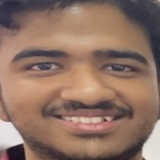

In [144]:
f1 = Image.fromarray(face1.astype(np.uint8))
f1

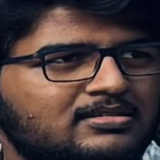

In [145]:
# face2 = extract_face(img2, faces2["face_5"]["facial_area"], image_size=160)
f2 = Image.fromarray(face2.astype(np.uint8))
f2

In [146]:
embedding1 = embedding_deepface(face1)
embedding2 = embedding_deepface(face2)
F.cosine_similarity(embedding1, embedding2).item()

0.653842568397522

In [147]:
embedding1.shape

torch.Size([1, 512])

## CLIP for the Rescue

In [109]:
from sentence_transformers import SentenceTransformer, util
from PIL import Image

In [209]:
model = SentenceTransformer("clip-ViT-B-16")

In [210]:
import pickle
with open("clip.pkl", "wb") as f:
    pickle.dump(model, f)

In [211]:
with open("clip.pkl", "rb") as f:
    model = pickle.load(f)

In [221]:
f1_embedding = model.encode(f1)
f2_embedding = model.encode(f2)

In [219]:
f1_embedding.tolist()[0]

-0.49898481369018555

In [213]:
cos_scores = util.pytorch_cos_sim(f1_embedding, f2_embedding)
cos_scores[0][0]

tensor(0.8996)

Nope not this time!

## Face Recognition Library

In [340]:
import face_recognition

In [349]:
picture_of_me = face_recognition.load_image_file(
    "./datasets/people/61705984-3729-47CB-A20B-DD1CFF9B9BA7_1_105_c.jpeg"
)
my_face_encoding = face_recognition.face_encodings(picture_of_me)[0]

In [357]:
unknown_picture = face_recognition.load_image_file(
    "./datasets/people/F2FBFB11-C7F0-4C32-8B6B-060508F3DD68_1_105_c.jpeg"
)
unknown_face_encoding = face_recognition.face_encodings(unknown_picture)[0]

In [358]:
results = face_recognition.compare_faces([my_face_encoding], unknown_face_encoding)
results

[True]

In [448]:
import requests

url = "https://github.com/Saafke/EDSR_Tensorflow/blob/master/models/EDSR_x2.pb"

with open("EDSR_x2.pb", "wb") as f:
    f.write(requests.get(url).content)

In [104]:
import cv2

In [153]:
def upscale_face(image_path, model_path, upscale_factor):
    # img = cv2.imread(image_path)
    img = image_path
    sr = cv2.dnn_superres.DnnSuperResImpl_create()
    sr.readModel(model_path)
    sr.setModel("edsr", upscale_factor)
    upscaled_img = sr.upsample(img)
    return upscaled_img

image = face1
model = "EDSR_x2.pb"
upscale_factor = 3


In [154]:
result1 = upscale_face(face1, model, upscale_factor)
result2 = upscale_face(face2, model, upscale_factor)

In [155]:
emb1 = embedding_deepface(result1)
emb2 = embedding_deepface(result2)

In [156]:
util.pytorch_cos_sim(emb1, emb2)

tensor([[0.6532]])

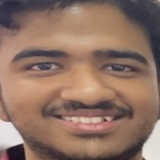

In [160]:
Image.fromarray(face1.astype(np.uint8))

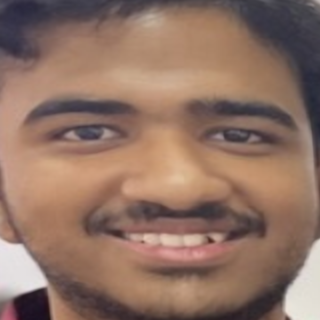

In [161]:
Image.fromarray(result1)